In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import *


In [6]:
# reading in data from the first protein
protein_names = ['O43526', 'P01009', 'P06576', 'P17181', 'P60484', 'P69905', 'Q5S007', 'Q86VV8', 'Q969H0']
# protein_name = protein_names[0]
# df = pd.read_csv(f"data/AF-{protein_name}-F1-model_v3.tsv", sep='\t')
# df

In [2]:
# Takes an array of values and returns a 2d array containing the variance of every subsegment.
def diff_matrix(x):
    M = np.outer(np.ones_like(x), x)
    return M - M.T

def extended_cumsum(x):
    return np.concatenate([[0], x.cumsum()])

def diff_matrix2(x):
    M = diff_matrix(extended_cumsum(x))
    return M[:-1, 1:]

def subsegment_variances(A):

    one = np.ones(len(A))
    segsize = diff_matrix2(one)
    segsize = np.where(segsize >= 1, segsize, np.nan)
    
    segsum = diff_matrix2(A)
    segmean = segsum/segsize

    segsqsum = diff_matrix2(A**2)

    segvar = segsqsum/segsize - segmean**2

    return segvar, segmean

subsegment_variances(np.arange(3))

(array([[0.        , 0.25      , 0.66666667],
        [       nan, 0.        , 0.25      ],
        [       nan,        nan, 0.        ]]),
 array([[0. , 0.5, 1. ],
        [nan, 1. , 1.5],
        [nan, nan, 2. ]]))

In [7]:

for protein_name in protein_names:
    df = pd.read_csv(f"data/AF-{protein_name}-F1-model_v3.tsv", sep='\t')
    x_vars, _ = subsegment_variances(df.x)
    y_vars, _ = subsegment_variances(df.y)
    z_vars, _ = subsegment_variances(df.z)
    _, obs_means = subsegment_variances(df.obs)
    _, exp_means = subsegment_variances(df.exp)
    vars = x_vars + y_vars + z_vars
    
    obs_mean = df.obs.mean()

    one = np.ones(len(df))
    iota = one.cumsum()
    segsize = diff_matrix2(one)
    segsize = np.where(segsize >= 1, segsize, np.nan)


    score = (segsize-1) / (vars * (obs_means + 1/segsize))
    score = np.nan_to_num(score, nan=0)


    a = np.argmax(score)
    start, end = a // len(df), a % len(df)

    # plt.imshow(score)
    # print(start, end)

    selection = np.logical_and(iota > start, iota <= end).reshape((-1))
    selection_gamma = df.obs.values[selection].sum() / df.exp.values[selection].sum()
    other_gamma = df.obs.values[np.logical_not(selection)].sum() / df.exp.values[np.logical_not(selection)].sum()

    scores = np.where(selection, selection_gamma, other_gamma)
    save_colouring(scores, f"data/{protein_name}_proximity_scores.tsv")

    

    

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_8800\1619683083.py:18: RuntimeWarning: invalid value encountered in divide
  score = (segsize-1) / (vars * (obs_means + 1/segsize))
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_8800\1619683083.py:18: RuntimeWarning: invalid value encountered in divide
  score = (segsize-1) / (vars * (obs_means + 1/segsize))
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_8800\1619683083.py:18: RuntimeWarning: invalid value encountered in divide
  score = (segsize-1) / (vars * (obs_means + 1/segsize))
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_8800\1619683083.py:18: RuntimeWarning: invalid value encountered in divide
  score = (segsize-1) / (vars * (obs_means + 1/segsize))
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_8800\1619683083.py:18: RuntimeWarning: invalid value encountered in divide
  score = (segsize-1) / (vars * (obs_means + 1/segsize))
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_8800\1619683083.py:18: RuntimeWarning: invalid value encountered in divide
 

In [97]:


x_vars, _ = subsegment_variances(df.x)
y_vars, _ = subsegment_variances(df.y)
z_vars, _ = subsegment_variances(df.z)
_, obs_means = subsegment_variances(df.obs)


N = len(df)
ONE = np.ones((N, 1))

cum_obs = df.obs.values.cumsum().reshape((-1, 1))
subseq_obs = np.maximum(diff_matrix(cum_obs), 0)

cum_exp = df.exp.values.cumsum().reshape((-1, 1))
subseq_exp = np.maximum(diff_matrix(cum_exp), 0.0001)

gamma = subseq_obs/subseq_exp

# generate pairwise distances
# N = len(df)
# dists = np.zeros(shape=(N, N))
# for a in range(N):
#     for b in range(a, N):
#         dists[a][b] = (df.x[a]-df.x[b])**2 + (df.y[a]-df.y[b])**2 + (df.z[a]-df.z[b])**2

# np.maximum((cum_obs @ ONE.T), 0).shape

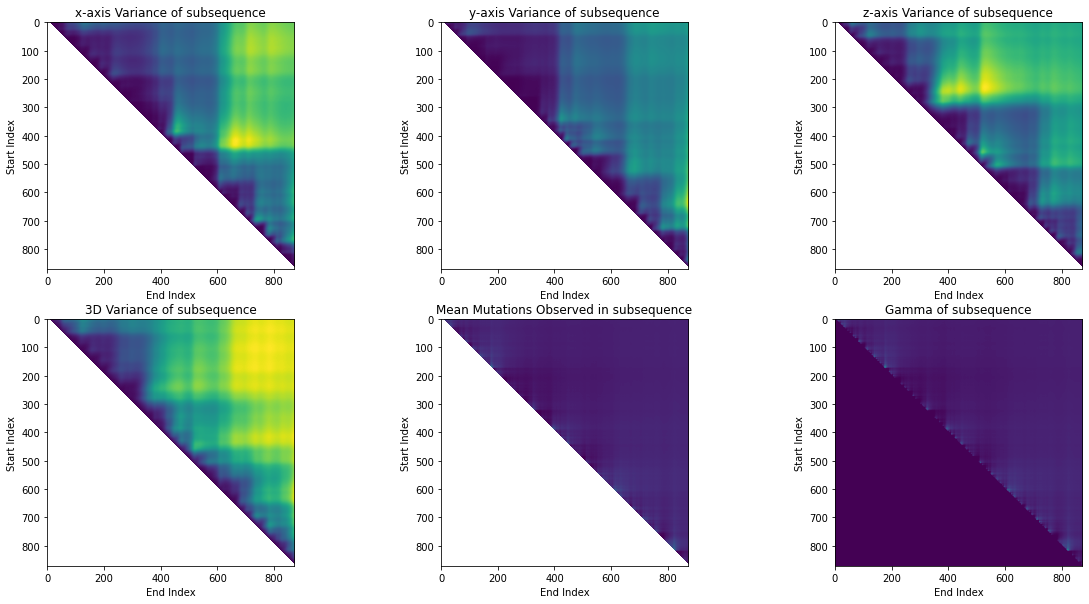

In [98]:
plt.rcParams['figure.figsize'] = [20, 10]


domains = [(96, 318), (466,650)]



plt.rcParams['figure.figsize'] = [20, 10]


# plot
# fig, ax = plt.subplots(3, 4)
fig, ax = plt.subplots(2, 3)

ax[0][0].set_title('x-axis Variance of subsequence')
ax[0][0].set_ylabel('Start Index')
ax[0][0].set_xlabel('End Index')
ax[0][0].imshow(x_vars)

ax[0][1].set_title('y-axis Variance of subsequence')
ax[0][1].set_ylabel('Start Index')
ax[0][1].set_xlabel('End Index')
ax[0][1].imshow(y_vars)

ax[0][2].set_title('z-axis Variance of subsequence')
ax[0][2].set_ylabel('Start Index')
ax[0][2].set_xlabel('End Index')
ax[0][2].imshow(z_vars)

ax[1][0].set_title('3D Variance of subsequence')
ax[1][0].set_ylabel('Start Index')
ax[1][0].set_xlabel('End Index')
ax[1][0].imshow(x_vars + y_vars + z_vars)

ax[1][1].set_title('Mean Mutations Observed in subsequence')
ax[1][1].set_ylabel('Start Index')
ax[1][1].set_xlabel('End Index')
ax[1][1].imshow(obs_means)

ax[1][2].set_title('Gamma of subsequence')
ax[1][2].set_ylabel('Start Index')
ax[1][2].set_xlabel('End Index')
ax[1][2].imshow(gamma)
# for i in range(2):
#     for j in range(3):
#         ax[i][j].plot([96, 318, 318, 466, 650, 650], [96, 96, 318, 466, 466, 640])

# ax[2][1].imshow(dists)


plt.show()

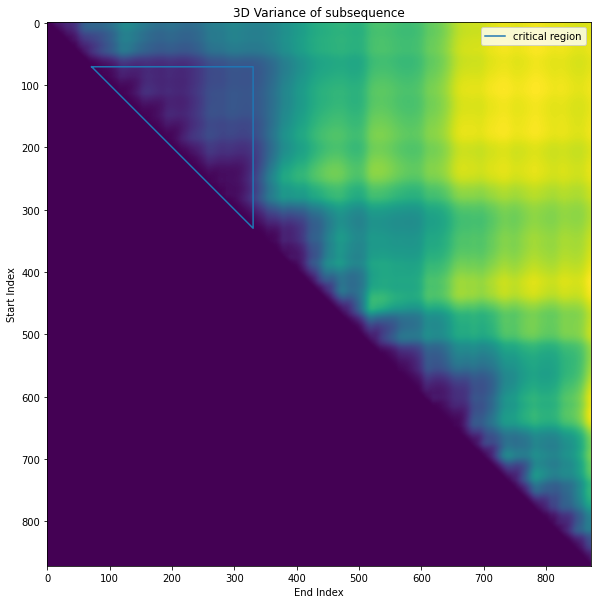

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
var_3d: np.ndarray = x_vars + y_vars + z_vars
var_3d = np.where(np.isnan(var_3d), 0, var_3d)

# since the grid is 50% full of 0s, the 60th percentile corresponds to the 20th percentile of actual data.
perc_10 = np.percentile(var_3d, 60)

IOTA = np.arange(N).reshape((-1, 1))
# start_index = IOTA @ ONE.T
# end_index = ONE @ IOTA.T
segment_size = ONE @ IOTA.T - IOTA @ ONE.T
segment_size = np.where(var_3d < perc_10, segment_size, 0)
mx = np.argmax(segment_size)

si, ei = mx // N, mx % N
fig, ax = plt.subplots()
ax.set_title('3D Variance of subsequence')
ax.set_ylabel('Start Index')
ax.set_xlabel('End Index')
plt.imshow(var_3d)
plt.plot([si, ei, ei, si], [si, si, ei, si], label="critical region")
plt.legend()
plt.show()

In [100]:
selection = np.logical_and(IOTA > si, IOTA <= ei).reshape((-1))
selection_gamma = df.obs.values[selection].sum() / df.exp.values[selection].sum()
other_gamma = df.obs.values[np.logical_not(selection)].sum() / df.exp.values[np.logical_not(selection)].sum()

scores = np.where(selection, selection_gamma, other_gamma)
save_colouring(scores, f"data/{protein_name}_proximity_scores.tsv")



In [101]:
selection_gamma, other_gamma

(0.4618049647771493, 0.5447061398301398)

array([[ 0.00000000e+00,  0.00000000e+00,  5.54611704e+00, ...,
         6.83807458e+02,  6.83590983e+02,  6.83310000e+02],
       [            nan, -0.00000000e+00,  3.52755850e+00, ...,
         6.84660048e+02,  6.84445181e+02,  6.84165572e+02],
       [            nan,             nan,  5.77315973e-14, ...,
         6.85510904e+02,  6.85297666e+02,  6.85019456e+02],
       ...,
       [            nan,             nan,             nan, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [            nan,             nan,             nan, ...,
                    nan,  0.00000000e+00,  0.00000000e+00],
       [            nan,             nan,             nan, ...,
                    nan,             nan,  0.00000000e+00]])

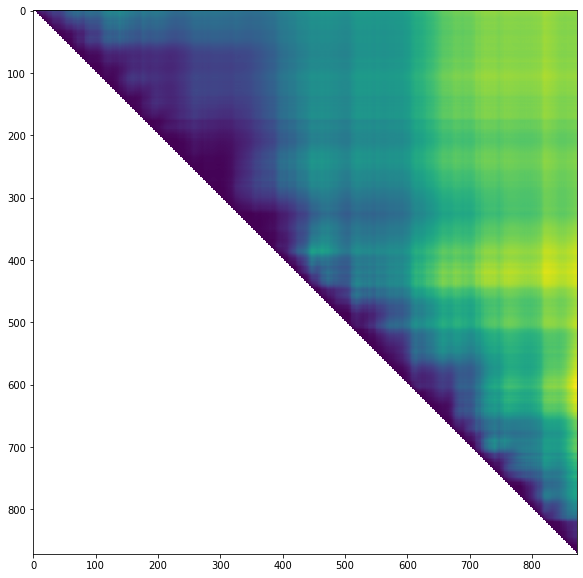

In [102]:
vars = x_vars + y_vars + z_vars
# print(obs_means)sasa
# print(np.around(vars/vars.mean() + obs_means/obs_means.mean(), 1))
# wavg = np.around(vars/vars.mean() + obs_means/obs_means.mean())

iota = np.arange(N) + 1
segsize = diff_matrix(iota)
segsize = np.where(segsize >= 1, segsize, np.nan)

# wavg = (vars + 0.001) * (obs_means + 0.001)
wavg = vars * obs_means
a = np.array([[max(0, i-j) for i in range(N)] for j in range(N)])
plt.imshow(wavg)

# Final answer is take the longest low-valued region and colour that differently to the rest
wavg

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_1404\2240285954.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(a/wavg)
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_1404\2240285954.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(a/wavg)


array([[  1,   2,   3, ..., 870, 871, 872],
       [  1,   1,   2, ..., 869, 870, 871],
       [  1,   1,   1, ..., 868, 869, 870],
       ...,
       [  1,   1,   1, ...,   1,   2,   3],
       [  1,   1,   1, ...,   1,   1,   2],
       [  1,   1,   1, ...,   1,   1,   1]])

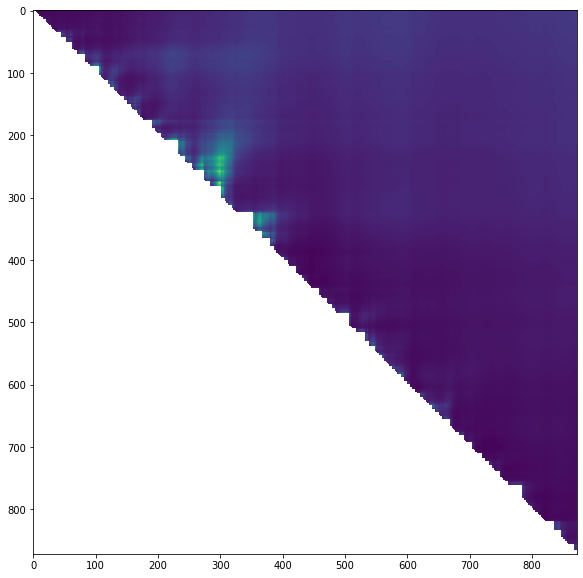

In [113]:
plt.imshow(a/wavg)
a + 1

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_1404\662226208.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(wavg/np.sqrt(a))
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_1404\662226208.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(wavg/np.sqrt(a))


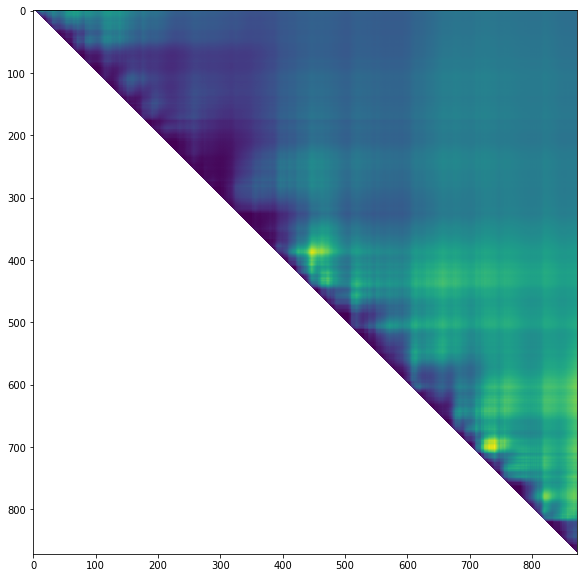

In [104]:
plt.imshow(wavg/np.sqrt(a))

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_1404\2312972238.py:18: RuntimeWarning: invalid value encountered in divide
  score = (segsize-1) / (vars * (obs_means + 1/segsize))


1069 1098


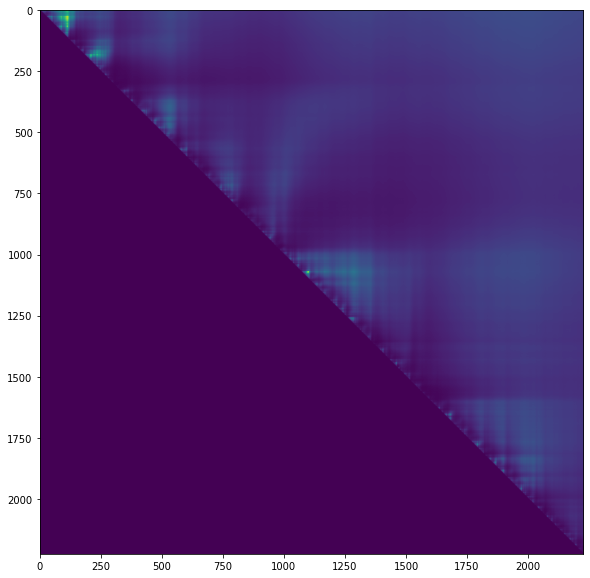

In [106]:

plt.hist(data['gamma'])

NameError: name 'data' is not defined

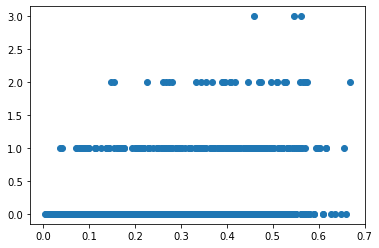

In [ ]:

plt.scatter(data.gamma*data.exp, data.obs)

In [ ]:


# a = np.array([0, 1, 2])
# subsegment_variances(df.x)

array([[            nan,  0.00000000e+00,  1.12572100e+00, ...,
         9.57712080e+02,  9.56933146e+02,  9.56030717e+02],
       [            nan,             nan, -2.22044605e-16, ...,
         9.58507595e+02,  9.57727571e+02,  9.56823755e+02],
       [            nan,             nan,             nan, ...,
         9.59378985e+02,  9.58597691e+02,  9.57692326e+02],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,  5.66124925e-11,  3.33975625e+00],
       [            nan,             nan,             nan, ...,
                    nan,             nan,  3.25322685e-11],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])